In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from tqdm import tqdm

from kuramoto import Kuramoto, plot_phase_coherence, plot_activity

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.6)

In [2]:
def make_asymmetric_adjmat(n):
    adjmat = np.random.random((100, 100))
    adjmat = (adjmat > .5).astype(int)
    adjmat[np.diag_indices_from(adjmat)] = 0
    return adjmat

In [3]:
# Instantiate a random graph and transform into an adjacency matrix
n_nodes = 100
adjmat = make_asymmetric_adjmat(n_nodes)
(adjmat == adjmat.T).all()

False

In [4]:
# Instantiate model with parameters
model = Kuramoto(coupling=3, dt=0.01, T=10, n_nodes=n_nodes)

# Run simulation - output is time series for all nodes (node vs time)
act_mat = model.run(adj_mat=adjmat)

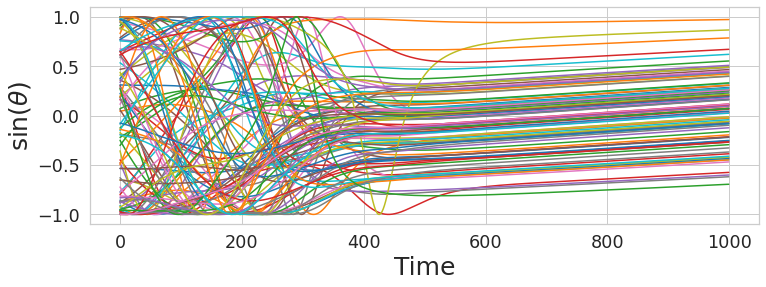

In [5]:
# Plot all the time series
plot_activity(act_mat);

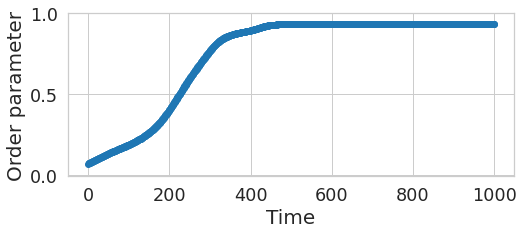

In [6]:
# Plot evolution of global order parameter R_t
plot_phase_coherence(act_mat);

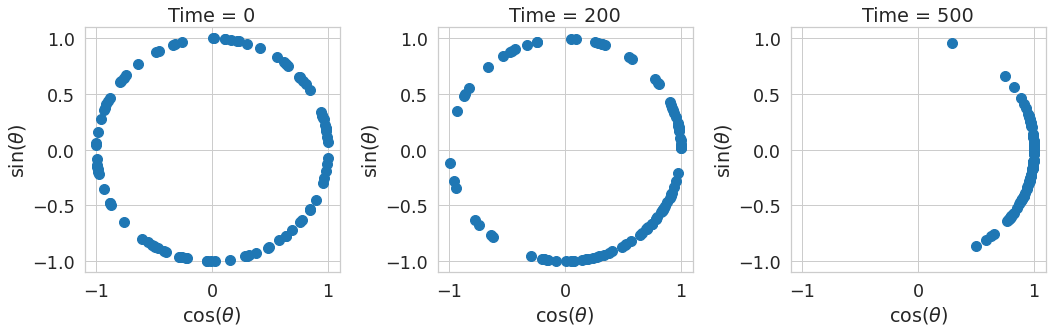

In [7]:
# Plot oscillators in complex plane at times t = 0, 250, 500
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 5),
                         subplot_kw={
                             "ylim": (-1.1, 1.1),
                             "xlim": (-1.1, 1.1),
                             "xlabel": r'$\cos(\theta)$',
                             "ylabel": r'$\sin(\theta)$',
                         })

times = [0, 200, 500]
for ax, time in zip(axes, times):
    ax.plot(np.cos(act_mat[:, time]),
            np.sin(act_mat[:, time]),
            'o',
            markersize=10)
    ax.set_title(f'Time = {time}')
plt.tight_layout()

100%|██████████| 100/100 [00:20<00:00,  4.92it/s]


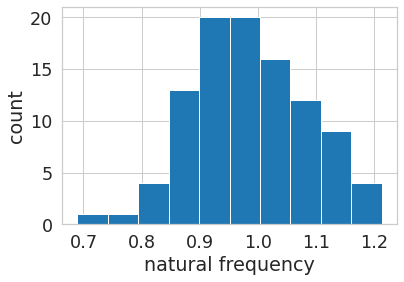

In [8]:
# Run model with different coupling (K) parameters
coupling_vals = np.linspace(0, 0.6, 100)
runs = []
for coupling in tqdm(coupling_vals):
    model = Kuramoto(coupling=coupling, dt=0.1, T=500, n_nodes=n_nodes)
    model.natfreqs = np.random.normal(1, 0.1, size=n_nodes)  # reset natural frequencies
    act_mat = model.run(adj_mat=adjmat)
    runs.append(act_mat)

# Check that natural frequencies are correct (we need them for prediction of Kc)
plt.figure()
plt.hist(model.natfreqs)
plt.xlabel('natural frequency')
plt.ylabel('count')

# Plot all time series for all coupling values (color coded)
runs_array = np.array(runs)

100it [00:14,  6.86it/s]


Text(0.5, 0, 'time')

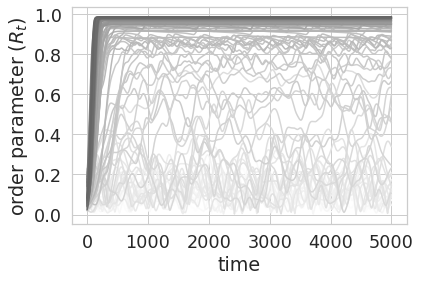

In [9]:
plt.figure()
for i, coupling in tqdm(enumerate(coupling_vals)):
    plt.plot(
        [model.phase_coherence(vec)
         for vec in runs_array[i, ::].T],
        c=str(1-coupling),  # higher -> darker   
    )
plt.ylabel(r'order parameter ($R_t$)')
plt.xlabel('time')

100it [00:03, 30.96it/s]


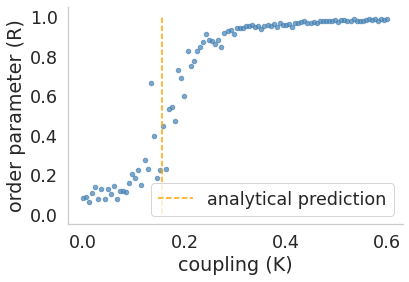

In [10]:
# Plot final Rt for each coupling value
plt.figure()
for i, coupling in tqdm(enumerate(coupling_vals)):
    r_mean = np.mean([model.phase_coherence(vec)
                      for vec in runs_array[i, :, -1000:].T]) # mean over last 1000 steps
    plt.scatter(coupling, r_mean, c='steelblue', s=20, alpha=0.7)

# Predicted Kc – analytical result (from paper)
Kc = np.sqrt(8 / np.pi) * np.std(model.natfreqs) # analytical result (from paper)
plt.vlines(Kc, 0, 1, linestyles='--', color='orange', label='analytical prediction')

plt.legend()
plt.grid(linestyle='--', alpha=0.8)
plt.ylabel('order parameter (R)')
plt.xlabel('coupling (K)')
sns.despine()